# Denoising Diffusion Probabilistic Models (DDPM)

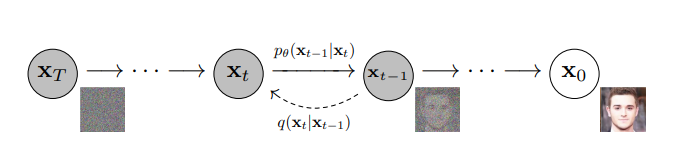

We want to generate images from noise. We do that using diffusion models - models that is a parametrized Markov chain trained using variational inference to produce samples matching the data. Diffusion models are efficient to train, but difficult to sample. This paper is an advancement of sampling from noise to generate good quality images.

Let $\beta_{1}, ..., \beta_{T}$ refers to some noise schedule. The diffusion process refers to the idea that $\mathbf{x}_{0}$ can be distorted into noise by a diffusion process given by a Markov chain:

$q(\mathbf{x}_{1:T}|\mathbf{x}_{0}) := \prod_{1}^{T}q(\mathbf{x}_{t}|\mathbf{x}_{t-1}), \quad q(\mathbf{x}_{t}|\mathbf{x}_{t-1}) := \mathcal{N}(\mathbf{x}_{t}; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1}, \beta_{t}\mathbf{I})$

We want to learn the inverse map:

$p_{\theta}(\mathbf{x}_{0:T}) := p(\mathbf{x}_{T})\prod_{1}^{T}p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t}), \quad p(\mathbf{x}_{t-1}|\mathbf{x}_{t}) := \mathcal{N}(\mathbf{x}_{t-1}; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t), \mathbf{\Sigma}(\mathbf{x}_{t},t))$

The objective is to learn $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$(usually some neural network architecture) and figure out how to sample from it to generate images.

In [1]:
# Adding previous directory to path to find miniAI since it is not registered as a module
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniAI.datasets import *
from miniAI.conv import *
from miniAI.learner import *
from miniAI.activations import *
from miniAI.init import *
from miniAI.sgd import *
from miniAI.resnet import *
from miniAI.augment import *

In [3]:
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

# We consider a simple problem of the MNIST Fashion dataset

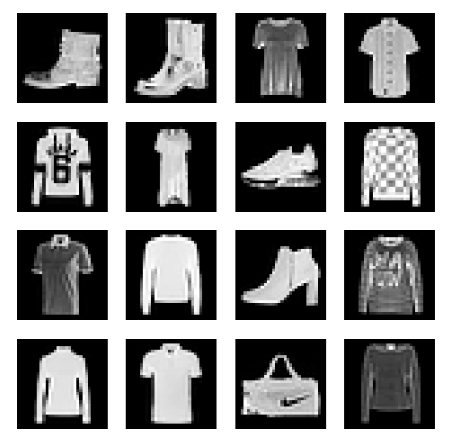

In [4]:

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [7]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

C:\Users\tktan\anaconda3\envs\diffusion\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([128, 1, 32, 32]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

We cheat and import UNet2DModel using HuggingFace APIs for now

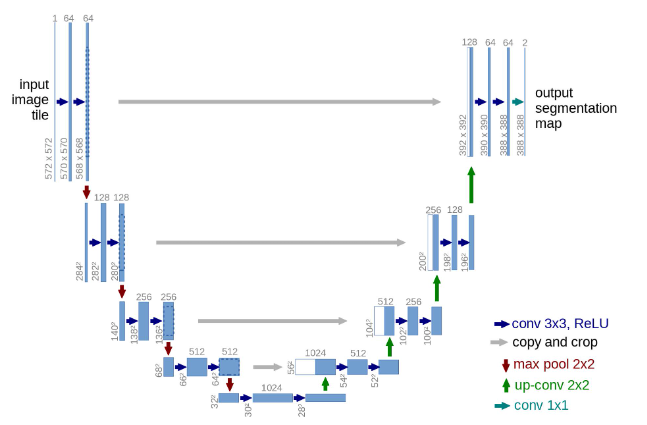

In [8]:
from diffusers import UNet2DModel
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

# How to train?

# 1. Training algorithm

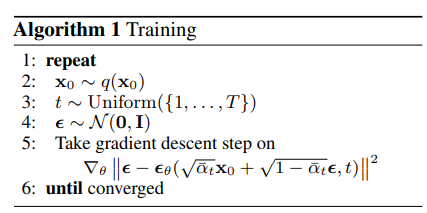

# 2. Sampling algorithm

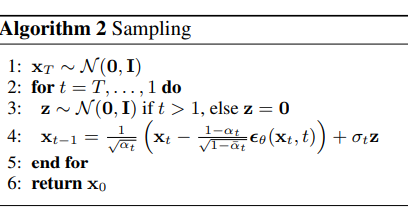

In [9]:
class DDPMCB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        device = learn.batch[0].device
        # 1.2 Grab the data
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # 1.3 select random timesteps for each image in the batch
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        # 1.4 sample the noise from normal distribution
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # 1.5: input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

In [10]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

loss,epoch,train
0.055,0,train
0.024,0,eval
0.022,1,train
0.020,1,eval
0.019,2,train
0.017,2,eval
0.017,3,train
0.016,3,eval
0.016,4,train
0.016,4,eval


C:\Users\tktan\anaconda3\envs\diffusion\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


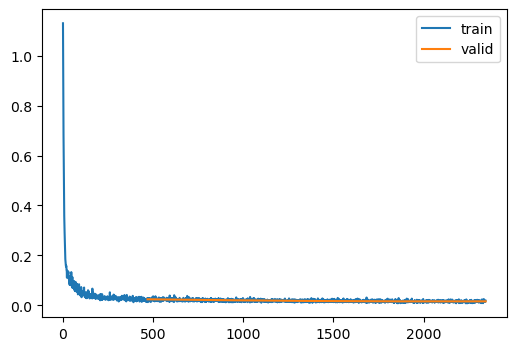

In [11]:
learn.fit(epochs)

# Inference

Generating images using algorithm 2

In [12]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

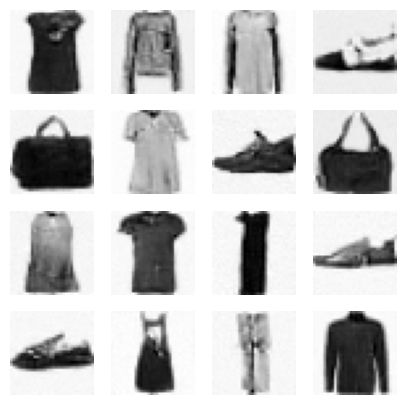

In [13]:
show_images(-samples[-1], figsize=(5,5))

  0%|          | 0/2 [00:00<?, ?it/s]

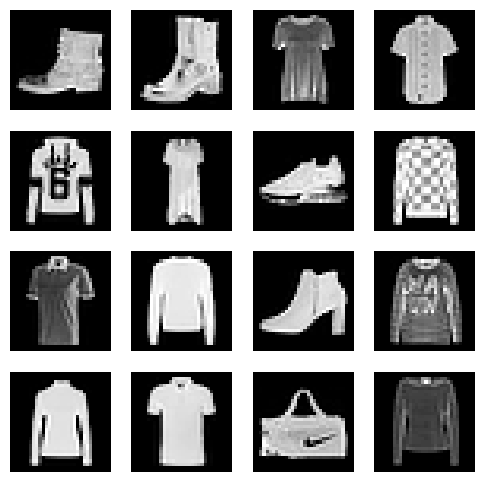

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)

dt = dls.train
xb,yb = next(iter(dt))

show_images(xb[:16], imsize=1.5)